## Intro to AI Assignment

## Team Members - Gamma B

#### Akhil
#### Akash
#### Jagadesh
#### Kapilesh
#### Sai Pranit
#### Sathwick


In [102]:
# Importing libraries
import pandas as pd
import numpy as np
from math import sqrt
import math
# Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn Model related libraries
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout,LSTM
from  keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from IPython.display import Image, display
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## Data Validation and Cleaning

In [3]:
# Let's Look The Dimensions Of The Data:
print(f'The Train dataset Contain {train.shape[0]} Rows and {train.shape[1]} Columns')

The Train dataset Contain 38999 Rows and 12 Columns


In [5]:
# Let's Look The Dimensions Of The Data:
print(f'The Test dataset Contain {test.shape[0]} Rows and {test.shape[1]} Columns')

The Test dataset Contain 802 Rows and 11 Columns


In [6]:
#Check Data Types
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


In [7]:
pd.value_counts(train.dtypes)

object     9
int64      2
float64    1
dtype: int64

In [8]:
## Converting date to datetime format and extracting the temporal features
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day


test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day


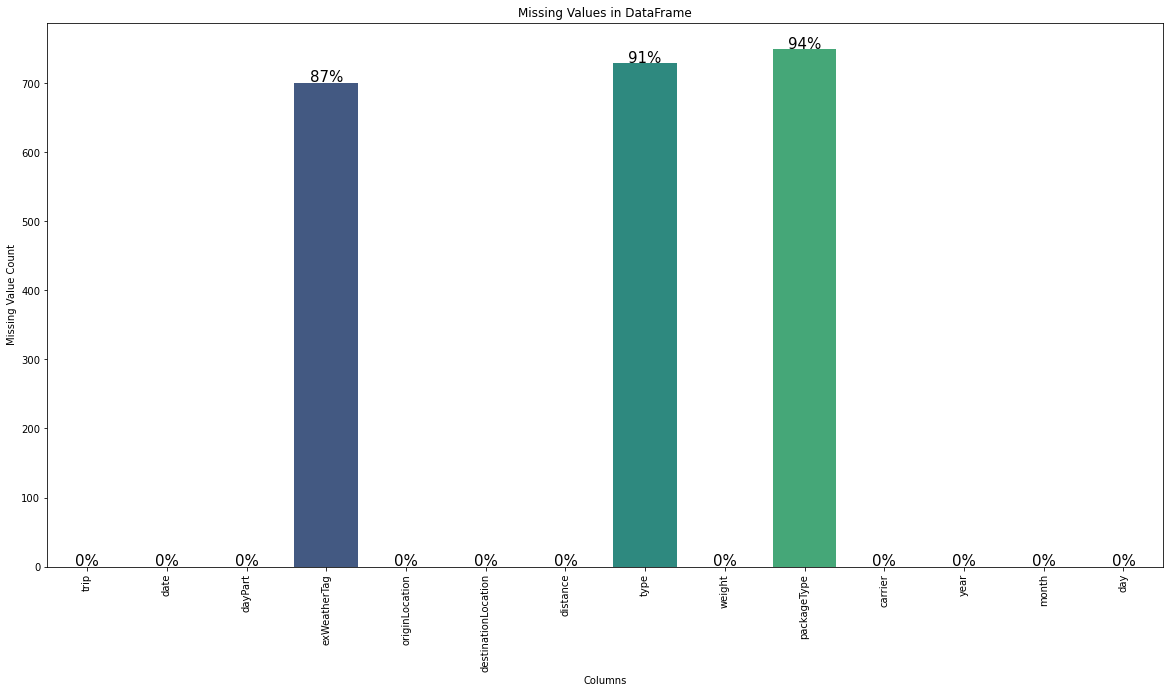

In [11]:
## Checking missing values and visualizing it

missing_counts = test.isnull().sum()
present_values=test.notnull().sum()
unique_value_counts = test.nunique()
total_count = len(test)
missing_percentage= (missing_counts / total_count) * 100
present_percentage= (present_values / total_count) * 100
unique_percentage= (unique_value_counts / total_count) * 100

# Plotting the missing values % in the dataset
plt.figure(figsize=(20, 10))
ax=sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')

# Add labels and title
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.xticks(rotation=90)

for p, label in zip(ax.patches, missing_percentage):
    ax.annotate(f'{label:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=15, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

In [10]:
# Sample of the unique elements of the features
Unique_values_list=[]
for column in train.columns:
    unique_values = train[column].unique().tolist()
    num_unique=train[column].nunique()
    if num_unique==1:
      Unique_values_list.append(column)
    print("{} Unique values in '{}': {} ".format(num_unique,column,unique_values[:5]))
print(Unique_values_list)

38999 Unique values in 'trip': ['t52712528', 't29859381', 't25702332', 't27713405', 't49439220'] 
1074 Unique values in 'date': [1504656000000000000, 1508544000000000000, 1500076800000000000, 1508630400000000000, 1576022400000000000] 
2 Unique values in 'dayPart': ['night', 'day'] 
2 Unique values in 'exWeatherTag': [nan, 'snow', 'heat'] 
9 Unique values in 'originLocation': ['S4', 'S8', 'S9', 'S6', 'S7'] 
9 Unique values in 'destinationLocation': ['D7', 'D1', 'D5', 'D4', 'D2'] 
17 Unique values in 'distance': [2200, 1800, 2800, 3200, 2000] 
1 Unique values in 'type': ['expedited', nan] 
499 Unique values in 'weight': [50, 12, 1, 43, 3] 
1 Unique values in 'packageType': [nan, 'TT'] 
4 Unique values in 'carrier': ['D', 'B', 'C', 'A'] 
3665 Unique values in 'cost': [68.41315193, 36.45064919, 9.05793866, 57.32008718, 77.2637771] 
3 Unique values in 'year': [2017, 2019, 2018] 
12 Unique values in 'month': [9, 10, 7, 12, 6] 
30 Unique values in 'day': [6, 21, 15, 22, 11] 
['type', 'package

#### Type, packageType and exWeatherTag have high missing %, so let's impute the missing values as 'Not_available' category since they seem to be important information.

## Feature Engineering

In [14]:
train = train.apply(lambda x: x.fillna('NA'))
test = test.apply(lambda x: x.fillna('NA'))

## Since it is a time series dataset, lets add date related features such as holiday_or_not, weekday_or_not

In [19]:
# using holidays library to get the holidays
import holidays

holiday_list = list()
print("--- Canada ---")
for date in holidays.Canada(years=[2014,2015,2016,2017,2018,2019], observed=True).items():
    print(str(date[0]), date[1])
    holiday_list.append([date[0], date[1]])
Holiday_dataset=pd.DataFrame(holiday_list,columns=['Date','Holiday'])

Holiday_dataset['Date'] = pd.to_datetime(Holiday_dataset['Date'])

# Create 'day_Holiday_or_not' column in train and test DataFrames
train['day_Holiday_or_not'] = train['date'].isin(Holiday_dataset['Date']).astype(int)
test['day_Holiday_or_not'] = test['date'].isin(Holiday_dataset['Date']).astype(int)
train['is_weekday'] = train['date'].apply(lambda x: 1 if x.weekday() < 5 else 0)
test['is_weekday'] = test['date'].apply(lambda x: 1 if x.weekday() < 5 else 0)
train['weekday']=train['date'].dt.day_name()
test['weekday']=test['date'].dt.day_name()

--- Canada ---
2016-01-01 New Year's Day
2016-03-25 Good Friday
2016-07-01 Canada Day
2016-09-05 Labour Day
2016-12-25 Christmas Day
2016-12-26 Christmas Day (Observed)
2017-01-01 New Year's Day
2017-01-02 New Year's Day (Observed)
2017-04-14 Good Friday
2017-07-01 Canada Day
2017-09-04 Labour Day
2017-12-25 Christmas Day
2018-01-01 New Year's Day
2018-03-30 Good Friday
2018-07-01 Canada Day
2018-09-03 Labour Day
2018-12-25 Christmas Day
2019-01-01 New Year's Day
2019-04-19 Good Friday
2019-07-01 Canada Day
2019-09-02 Labour Day
2019-12-25 Christmas Day
2014-01-01 New Year's Day
2014-04-18 Good Friday
2014-07-01 Canada Day
2014-09-01 Labour Day
2014-12-25 Christmas Day
2015-01-01 New Year's Day
2015-04-03 Good Friday
2015-07-01 Canada Day
2015-09-07 Labour Day
2015-12-25 Christmas Day


In [20]:
train.describe()

,distance,weight,cost,year,month,day,day_Holiday_or_not,is_weekday
count,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210,2017.995590,6.502910,15.472858,0.015052,0.713582
std,728.996843,75.473752,180.715055,0.815877,3.444621,8.611461,0.121760,0.452093
min,400.000000,1.000000,5.000000,2017.000000,1.000000,1.000000,0.000000,0.000000
25%,1400.000000,13.000000,38.768742,2017.000000,4.000000,8.000000,0.000000,0.000000
50%,2000.000000,25.000000,46.468476,2018.000000,6.000000,15.000000,0.000000,1.000000
75%,2600.000000,39.000000,70.239797,2019.000000,9.000000,23.000000,0.000000,1.000000
max,3600.000000,500.000000,2019.734797,2019.000000,12.000000,30.000000,1.000000,1.000000


In [21]:
train.describe(include=object)

,trip,dayPart,exWeatherTag,originLocation,destinationLocation,type,packageType,carrier,weekday
count,38999,38999,38999,38999,38999,38999,38999,38999,38999
unique,38999,2,3,9,9,2,2,4,7
top,t52712528,night,NA,S3,D8,NA,NA,B,Monday
freq,1,25904,34117,4461,4471,35251,36499,29813,5770


### Data Preprocessing

In [71]:
val_trip=test.pop('trip')
test.drop(columns=['date'],inplace=True)
train.drop(columns=['trip','date'],inplace=True)

Y=train.pop('cost')
X=train.copy()

#Splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
# Normalizing the variables
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train[numerical_columns] = pipeline.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = pipeline.transform(X_test[numerical_columns])
test[numerical_columns]=pipeline.transform(test[numerical_columns])


# EDA

### Univariate analysis

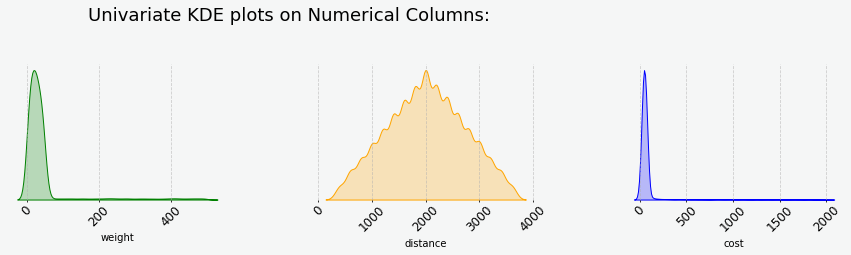

In [72]:
df=train.copy()
df['cost']=Y

# Create a figure with a specified size and set its background color with gridlines
fig = plt.figure(figsize=(15, 6))
fig.patch.set_facecolor('#f5f6f6')


# Create a 2x3 grid layout for subplots with specified spacing
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.4, hspace=0.4)

# Add subplots to the grid
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])


# Store the subplots in a list for easy access
axes = [ax0, ax1, ax2]

# Customize the appearance of each subplot
for ax in axes:
    ax.set_facecolor('#f5f6f6')  # Set background color
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines to subplot
    ax.tick_params(axis='x', labelsize=12, which='major', direction='out', pad=2, length=1.5,rotation=45)  # Customize x-axis ticks
    ax.tick_params(axis='y', colors='black')  # Set y-axis tick color
    ax.axes.get_yaxis().set_visible(False)  # Hide y-axis
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)  # Hide spines on all sides of the subplot

# Select numerical columns from the DataFrame
cols = ['weight','distance','cost']

# Modified colors for the KDE plots
kde_colors = ["green", "orange", "blue", "purple", "pink", "gray"]

# Plot KDE plots for each numerical column
for i, col in enumerate(cols):
    sns.kdeplot(x=df[col], color=kde_colors[i], fill=True, ax=axes[i])

# Add a title to the figure
fig.text(0.2, 0.98, "Univariate KDE plots on Numerical Columns:", **{'font': 'Roboto Mono', 'size': 18},
         alpha=1)

# Display the figure
plt.show()

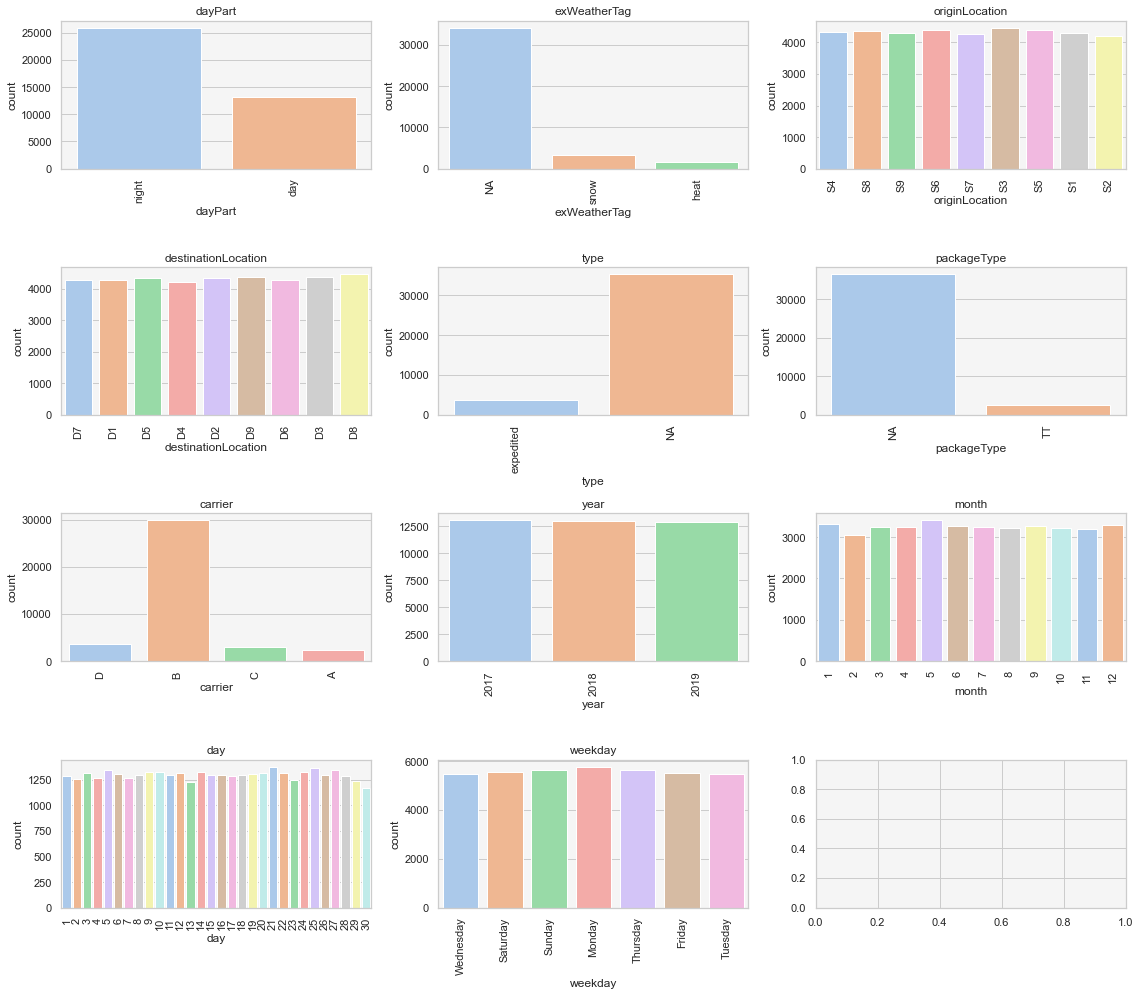

In [74]:
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f5f5f5"})
df['year']=df['year'].astype(object)
df['day']=df['day'].astype(object)
df['month']=df['month'].astype(object)
fields = df.select_dtypes(exclude="number").columns

figure_size = (16, 14)
cols = 3
rows = math.ceil(len(fields) / cols)

plt.subplots(rows, cols, figsize=figure_size)

for i, field in enumerate(fields, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x=field, data=df, palette="pastel")
    plt.title(field)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [75]:
df.skew()

distance             -0.008007
weight                4.153602
year                  0.008097
month                 0.000835
day                  -0.004710
day_Holiday_or_not    7.966052
is_weekday           -0.944910
cost                  6.969839
dtype: float64

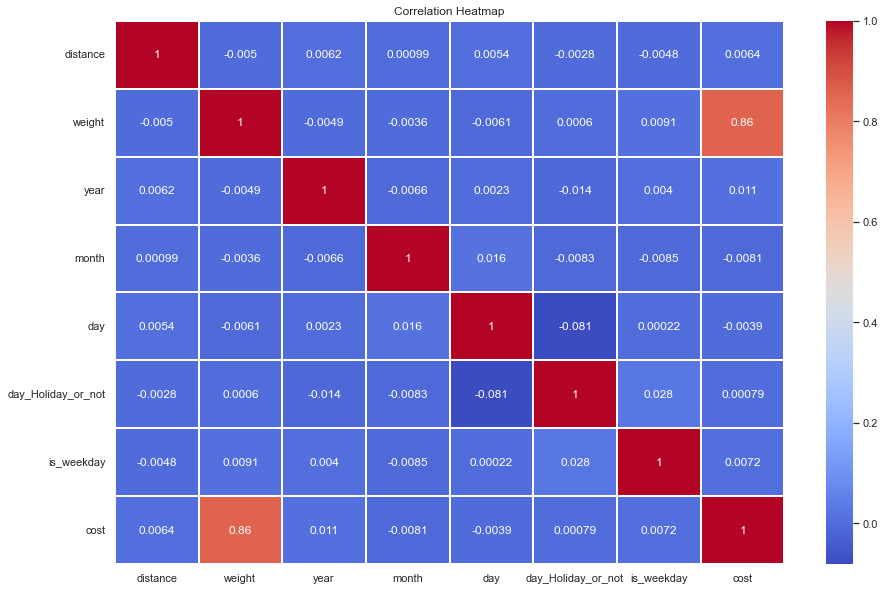

In [77]:
# Checking the relationship between the variables 
df['year']=df['year'].astype(int)
df['day']=df['day'].astype(int)
df['month']=df['month'].astype(int)
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.025)

plt.title('Correlation Heatmap')

plt.show()

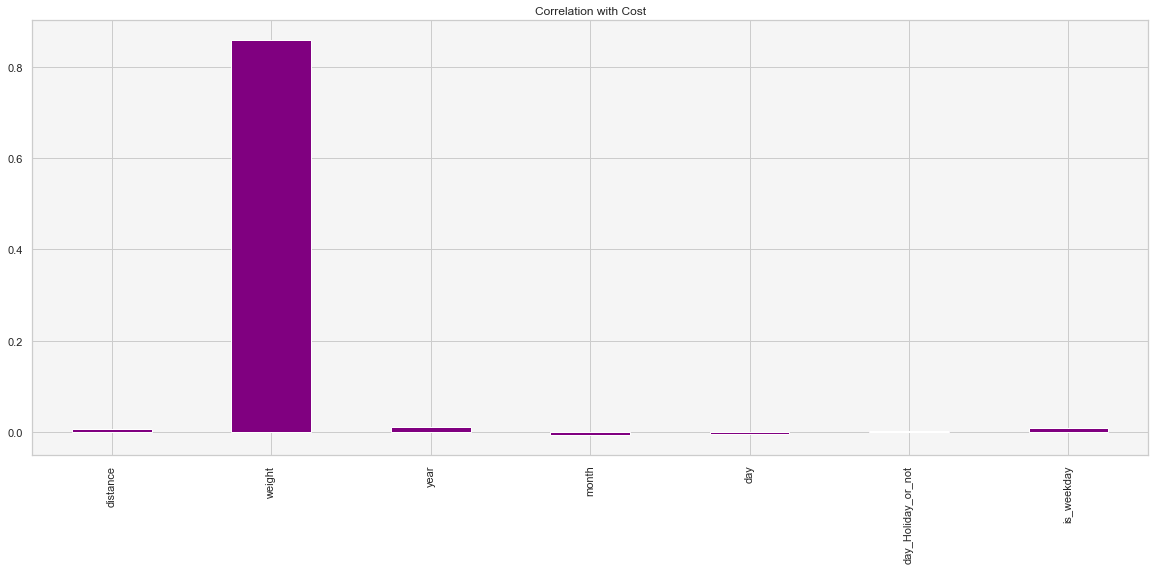

In [79]:
# Correlation plot for the target variable - Diabetes or not
df.drop('cost', axis=1).corrwith(df.cost).plot(kind='bar', grid=True, figsize=(20, 8)
, title="Correlation with Cost",color="Purple");


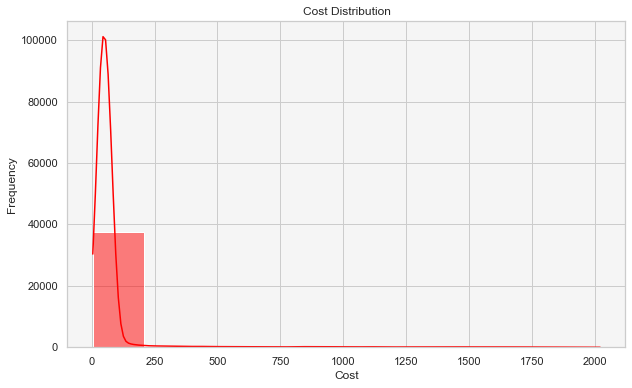

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(df['cost'], bins=10, kde=True, color='Red')
plt.title('Cost Distribution')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

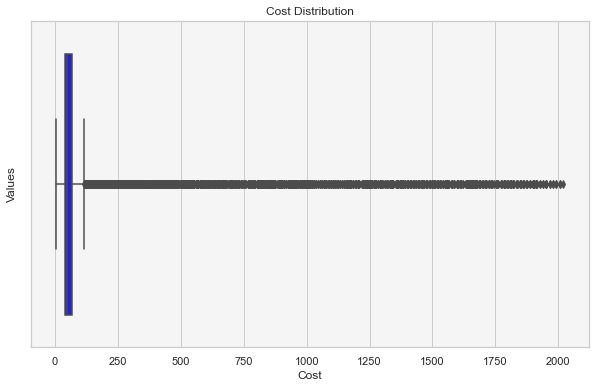

In [83]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['cost'], color='Blue')
plt.title('Cost Distribution')
plt.xlabel('Cost')
plt.ylabel('Values')
plt.show()

## Bivariate analysis

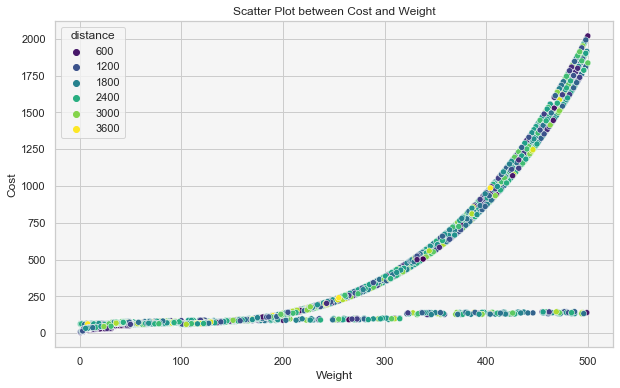

In [100]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='cost', data=df, palette='viridis', hue='distance', sizes=(50, 200))
plt.title('Scatter Plot between Cost and Weight')
plt.xlabel('Weight')
plt.ylabel('Cost')
plt.show()

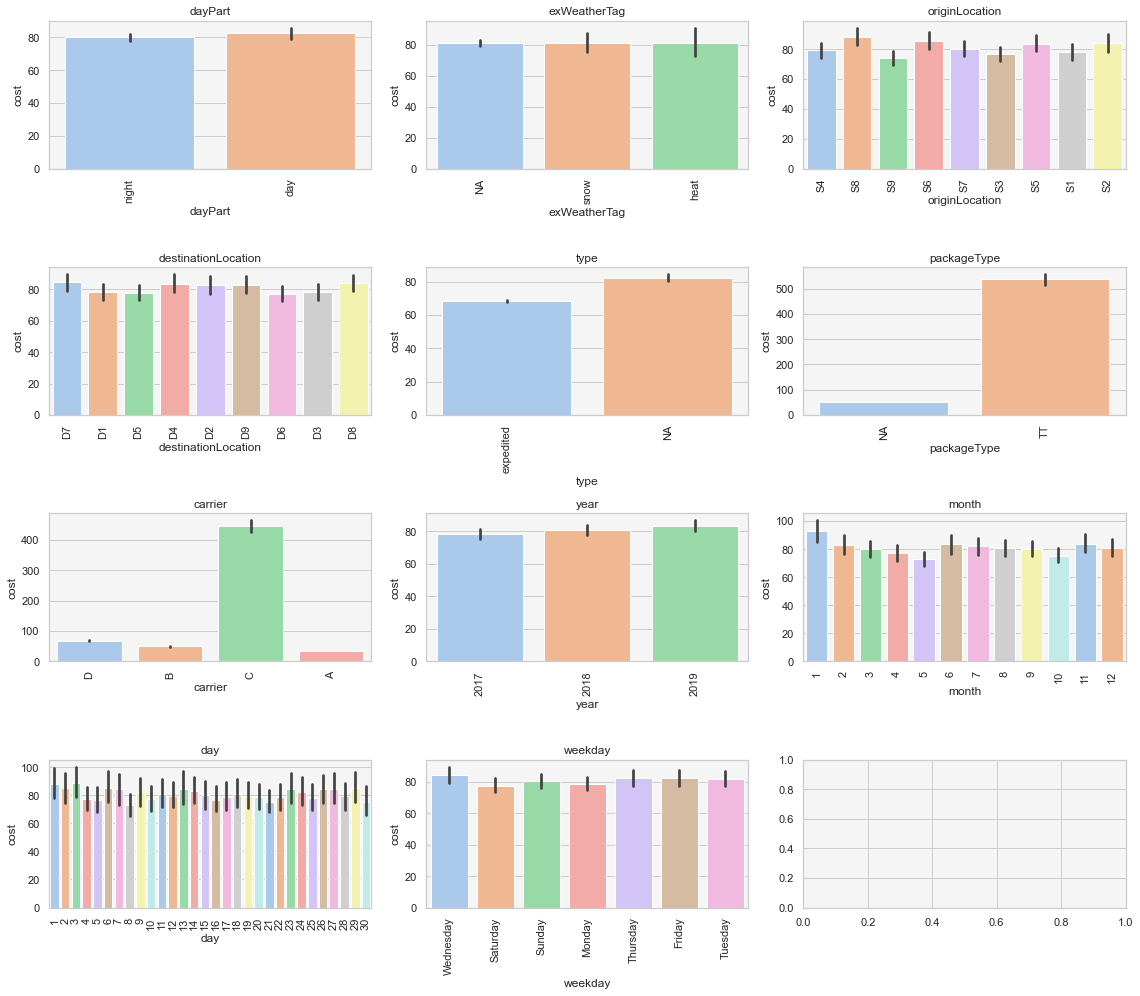

In [91]:
df['year']=df['year'].astype(object)
df['day']=df['day'].astype(object)
df['month']=df['month'].astype(object)
fields = df.select_dtypes(exclude="number").columns

figure_size = (16, 14)
cols = 3
rows = math.ceil(len(fields) / cols)

plt.subplots(rows, cols, figsize=figure_size)

for i, field in enumerate(fields, 1):
    plt.subplot(rows, cols, i)
    sns.barplot(x=field, y='cost', data=df, palette="pastel")
    plt.title(field)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Observations

* Locations and age are equally distributed.
* As weight increases the cost increases.
* Most deliveries are done during the night.
* Weight impacts the cost most and it has high correlation with cost.
* Cost doesn't change based on weather and daypart conditions.
* Cost is high if the packagetype is TT or if its carried by carrier C.
* Expedited packages have a slightly lower cost.
* Cost slightly increases by year.
* As the year starts the cost is high and it decreases till month 5 and it picks up after 6th month. October has a slight dip but it picks up after that.


### Outliers 

In [92]:
kk=(df.select_dtypes(include='number').columns).to_list()

df2=df[kk]


upper =df2.quantile(0.75)+1.5 *(df2.quantile(0.75)-df2.quantile(0.25))
lower = df2.quantile(0.25)-1.5 *(df2.quantile(0.75)-df2.quantile(0.25))

for i in kk:
    print('Column: ',i)   
    x= df2[ (df2[i]<round(lower[i],2)) |  (df2[i]>round(upper[i],2))][i].to_list()
    print('No of Outliers presesnt:',len(x))

Column:  distance
No of Outliers presesnt: 0
Column:  weight
No of Outliers presesnt: 2629
Column:  day_Holiday_or_not
No of Outliers presesnt: 587
Column:  is_weekday
No of Outliers presesnt: 0
Column:  cost
No of Outliers presesnt: 1867


#### Only the cost and weight have a lot of outliers, so let's not remove them because we don't know the distribution in the validation set

# Modeling

### Feature encoding: Let's encode one hot encoding of the train, test and val together and later split them. 

In [29]:


combined_df = pd.concat([X_train, X_test, test], axis=0)

# Perform one-hot encoding on the combined DataFrame
combined_df_encoded = pd.get_dummies(combined_df, columns=train.select_dtypes(exclude="number").columns.to_list())

# Split the combined DataFrame back into train, test, and val
train_encoded = combined_df_encoded.iloc[:len(X_train)]
test_encoded = combined_df_encoded.iloc[len(X_train):len(X_train) + len(X_test)]
val_encoded = combined_df_encoded.iloc[len(X_train) + len(X_test):]

In [32]:
# The below function trains the dataset for Linear Regression,Ridge regression, Xgboost and Catboost models and evaluates it based on the  
def train_models(X_train, X_test, y_train, y_test):
    model_dict = {
        "linear": LinearRegression(),
        "Ridge": Ridge(alpha=0.2),
        ##"KNN": KNeighborsRegressor(n_jobs=-1, n_neighbors=4),
        "XGB": XGBRegressor(random_state=42),
       ## "light": LGBMRegressor(random_state=42),
        "Cat": CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=False)
    }
    list1=[]
    dict1={}
    
    
    for model_name, model in model_dict.items() :
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        num_predictors = X_train.shape[1]

        n = X_train.shape[0]

        adjusted_r_squared = 1 - (1 - r2_score(y_test, pred)) * (n - 1) / (n - num_predictors - 1)
        
        print(f"Training loss for model {model_name}   MSE : {mean_squared_error(y_test, pred, squared=False),},RMSE : {sqrt(mean_squared_error(y_test, pred)),}, R-Square : {r2_score(y_test, pred),}, MAE : {mean_absolute_error(y_test, pred),} , Accuracy : {model.score(X_test,y_test)} ,Adjusted R-Square : {adjusted_r_squared}  ")
        dict1[model_name]=[mean_squared_error(y_test, pred),sqrt(mean_squared_error(y_test, pred)),r2_score(y_test, pred),
                           mean_absolute_error(y_test, pred),model.score(X_test,y_test)*100,adjusted_r_squared]
    return dict1

In [33]:
# Running the train_models function
dict1=train_models(train_encoded,test_encoded, y_train, y_test)

Training loss for model linear   MSE : (81.6144663137134,),RMSE : (81.6144663137134,), R-Square : (0.8098722881943007,), MAE : (41.40249987247436,) , Accuracy : 0.8098722881943007 ,Adjusted R-Square : 0.8095583503881415  
Training loss for model Ridge   MSE : (81.61736842557802,),RMSE : (81.61736842557802,), R-Square : (0.8098587665302301,), MAE : (41.4006551439411,) , Accuracy : 0.8098587665302301 ,Adjusted R-Square : 0.8095448063971755  
Training loss for model XGB   MSE : (1.7149978499386376,),RMSE : (1.7149978499386376,), R-Square : (0.9999160465996152,), MAE : (0.3463397212158473,) , Accuracy : 0.9999160465996152 ,Adjusted R-Square : 0.9999159079762336  
Training loss for model Cat   MSE : (1.58649023994922,),RMSE : (1.58649023994922,), R-Square : (0.9999281567549223,), MAE : (0.39570604624943556,) , Accuracy : 0.9999281567549223 ,Adjusted R-Square : 0.999928038127761  


## Since Catboost is our best model, we'll use gridsearch for hyperparameter tuning to find our best parameters.

In [104]:
# Instantiate CatBoostRegressor
cbr = CatBoostRegressor()

# Create a comprehensive grid with various hyperparameters
grid = {
    'depth': [6,9],
    'learning_rate': [ 0.1],
    'iterations': [100, 500],
    'subsample': [0.5, 0.9],
    'random_seed': [42]
}

# Define RMSE as the scoring metric
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred) ** 2)), greater_is_better=False)

# Instantiate GridSearchCV for CatBoostRegressor with the comprehensive grid and RMSE as the scoring metric
gscv = GridSearchCV(estimator=cbr, param_grid=grid, scoring=rmse_scorer, cv=5)

# Fit the grid search on the training data
gscv.fit(train_encoded, y_train)

# Print the best hyperparameters from the grid search
print('Best Hyperparameters:', gscv.best_params_)

# Use the best model from grid search for predictions
best_model = gscv.best_estimator_
y_pred = best_model.predict(test_encoded)

# Calculate evaluation metrics on the test data
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('The RMSE score of the CatBoost is', rmse)
print('The MAE score of the CatBoost is', mae)
print('The R2 score of the CatBoost is', r2)
print('The accuracy score of the CatBoost is', best_model.score(test_encoded, y_test) * 100)

0:	learn: 159.7948030	total: 3.78ms	remaining: 374ms
1:	learn: 145.3652410	total: 7.72ms	remaining: 378ms
2:	learn: 132.0005089	total: 11.5ms	remaining: 371ms
3:	learn: 120.0751425	total: 15.3ms	remaining: 366ms
4:	learn: 109.4678385	total: 19.4ms	remaining: 368ms
5:	learn: 99.7490146	total: 23.8ms	remaining: 372ms
6:	learn: 91.1082220	total: 28.3ms	remaining: 375ms
7:	learn: 83.0877648	total: 32.4ms	remaining: 372ms
8:	learn: 75.7022511	total: 36.1ms	remaining: 365ms
9:	learn: 68.6794968	total: 41ms	remaining: 369ms
10:	learn: 62.6454931	total: 45.5ms	remaining: 368ms
11:	learn: 57.0518922	total: 50.1ms	remaining: 367ms
12:	learn: 52.0116070	total: 54.2ms	remaining: 363ms
13:	learn: 47.4453131	total: 58ms	remaining: 356ms
14:	learn: 43.4589201	total: 62.3ms	remaining: 353ms
15:	learn: 39.6680920	total: 66ms	remaining: 347ms
16:	learn: 36.3079603	total: 69.6ms	remaining: 340ms
17:	learn: 33.2623817	total: 73.4ms	remaining: 334ms
18:	learn: 30.4769161	total: 77.2ms	remaining: 329ms
19:	

In [105]:
print('Best Hyperparameters:', gscv.best_params_)

Best Hyperparameters: {'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'random_seed': 42, 'subsample': 0.5}


In [34]:
# Our chosen model is CatBoostRegressor since it performs better than the other three models

model= CatBoostRegressor(loss_function='RMSE', verbose=False,
                         depth= 6, 
                         iterations= 2000, 
                         learning_rate= 0.1, 
                         random_seed= 42, subsample=0.9)

model.fit(train_encoded, y_train)
y_pred = model.predict(test_encoded)

rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the catboost is ',rmse)
print('The MAE score of the catboost ',mae)
print('The R2 score of the catboost is ',r2)
print('The accuracy score of the catboost is ',model.score(test_encoded,y_test)*100)

The RMSE score of the catboost is  1.58823662208795
The MAE score of the catboost  0.2991271710516708
The R2 score of the catboost is  0.9999279985001632
The accuracy score of the catboost is  99.99279985001633


## This was the model we used for kaggle compettition which provided a RMSE of 1.211 public score.

## Let's use adaboost to improve on the previous catboost.

In [38]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator = model,n_estimators=200,learning_rate=0.1)

ada.fit(train_encoded, y_train)
y_pred = ada.predict(test_encoded)

rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the catboost is ',rmse)
print('The MAE score of the catboost ',mae)
print('The R2 score of the catboost is ',r2)
print('The accuracy score of the catboost is ',ada.score(test_encoded,y_test)*100)

The RMSE score of the catboost is  0.6795211189527792
The MAE score of the catboost  0.1251449807349938
The R2 score of the catboost is  0.9999868199502696
The accuracy score of the catboost is  99.99868199502696


## This is the best model on our test set and had an rmse of 0.6 on val set also.

In [40]:
val_set=pd.DataFrame(val_trip)
val_set['cost']=ada.predict(val_encoded)
val_set.to_csv('Submission6.csv')

## Now that we know our best parameters and model, let's use the entire available data to train and predict on the validation set.

In [41]:
# Combining x_train and x_test
combined_x_train = pd.concat([train_encoded, test_encoded], axis=0)
combined_y_train = pd.concat([y_train, y_test], axis=0)

ada.fit(combined_x_train,combined_y_train)
y_pred = ada.predict(test_encoded)

rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the catboost is ',rmse)
print('The MAE score of the catboost ',mae)
print('The R2 score of the catboost is ',r2)
print('The accuracy score of the catboost is ',ada.score(test_encoded,y_test)*100)

The RMSE score of the catboost is  0.0647618394141029
The MAE score of the catboost  0.037675440082020006
The R2 score of the catboost is  0.9999998802847485
The accuracy score of the catboost is  99.99998802847485


In [42]:
val_set=pd.DataFrame(val_trip)
val_set['cost']=ada.predict(val_encoded)
val_set.to_csv('Submission7.csv')

## Ada improved the RMSE and after a submitting it to Kaggle we had the highest personal best of 0.4 public score and 0.3 private score 

## ANN using Tensorflow for Regression 

In [45]:
## Let's use a neural network with three layers and relu as the activation function
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 64, activation = tf.nn.relu, input_shape = [train_encoded.shape[1]]),
    tf.keras.layers.Dense(units = 64, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1)
    ])

In [51]:
nn_model.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(0.001), metrics = ['mae','mse'])

In [52]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2944      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = nn_model.fit(train_encoded, y_train, epochs = 500, validation_data=(test_encoded, y_test))

Epoch 1/500
854/854 [==============================] - 7s 4ms/step - loss: 18705.5449 - mae: 40.7741 - mse: 18705.5449 - val_loss: 10792.0996 - val_mae: 33.3102 - val_mse: 10792.0996
Epoch 2/500
854/854 [==============================] - 3s 4ms/step - loss: 7408.7778 - mae: 26.0265 - mse: 7408.7778 - val_loss: 5995.9268 - val_mae: 27.9946 - val_mse: 5995.9268
Epoch 3/500
854/854 [==============================] - 3s 4ms/step - loss: 3941.9333 - mae: 20.8830 - mse: 3941.9333 - val_loss: 3146.0684 - val_mae: 19.4915 - val_mse: 3146.0684
Epoch 4/500
854/854 [==============================] - 3s 4ms/step - loss: 2144.6558 - mae: 16.4668 - mse: 2144.6558 - val_loss: 1693.9675 - val_mae: 15.1118 - val_mse: 1693.9675
Epoch 5/500
854/854 [==============================] - 3s 4ms/step - loss: 1142.1394 - mae: 12.6334 - mse: 1142.1394 - val_loss: 971.5042 - val_mae: 16.5918 - val_mse: 971.5042
Epoch 6/500
854/854 [==============================] - 3s 4ms/step - loss: 558.2566 - mae: 9.7176 - mse

In [54]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
495,5.233289,0.937784,5.233289,7.245465,1.456009,7.245465
496,5.234665,0.938590,5.234665,6.713998,1.106439,6.713998
497,5.157828,0.932813,5.157828,4.491841,0.851876,4.491841
498,5.273247,0.933667,5.273247,10.313062,1.263892,10.313062
499,4.916996,0.930770,4.916996,5.187454,0.867891,5.187454


In [56]:
## Printing the NN results
y_pred = nn_model.predict(test_encoded)
rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the neural network is ',rmse)
print('The MAE score of the neural network ',mae)
print('The R2 score of the neural network is ',r2)

The RMSE score of the neural network is  2.27759863217814
The MAE score of the neural network  0.8678907700156109
The R2 score of the neural network is  0.9998519305313268


## The RMSE of Neural Networks is around 2.277 and adaboost has the lowest rmse of 0.647. So let's choose this model as our final model.

## Results

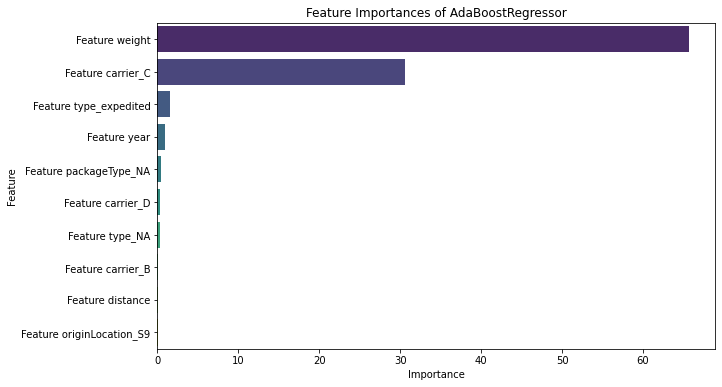

In [66]:
# Get feature importances
feature_importances = ada.feature_importances_

# Get feature names (assuming you have them)
feature_names = [f'Feature {i}' for i in train_encoded]

# Create a DataFrame for plotting
import pandas as pd
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort feature importances in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importances.head(10), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of AdaBoostRegressor')
plt.show()

## Results
* As we found from the EDA weight and Carrier C and expedited are the best predictors of the cost.

## Conclusion

* We chose catboost and adaboost as our final models, we used base models such as Linear regression, Ridge Regression, Xgboost and Catboost.
* The model was evaluated based on RMSE,MAE,R-Square and adjusted R-square.
* Our compettition kaggle score was 1.211 and our late submitted score improved to 0.4 RMSE on the validation set.
